# Libraries:

In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from IPython.display import display
from collections import Counter 
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
warnings.filterwarnings("ignore")

#GPU
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.visible_device_list = "0"
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.allow_growth = True

tf.compat.v1.keras.backend.set_session(tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)))

def set_seed(sd=123):  
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "D:\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "D:\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "D:\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "D:\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\IPython\core\

TypeError: can only concatenate str (not "list") to str

# Standardizing the data

In [5]:
#To make the data standard (standard normal distribution)
def standardizeLAB(X):  
    standX = np.zeros(X.shape)
    ## standardized one takes values between 0 and 1
    standX[:,:,:,0] =  X[:,:,:,0]/100.0
    ## standardized one takes values between -1 and 1
    standX[:,:,:,1:] = X[:,:,:,1:]/128.0
    return(standX)

# Building cnn model

In [6]:
#libraries to build the model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose,Flatten,MaxPool2D
from keras.models import Sequential
import keras.layers

#building the model
def define_model():
    #Design the neural network
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.compile(optimizer='rmsprop', loss='mse')
    return(model)

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 512)      

# dividing the dataset into batches

In [4]:
import time
batch_size = 16
def image_a_b_gen(Xtrain, batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        X_batch = batch[:,:,:,[0]]
        Y_batch = batch[:,:,:,1:] 
        yield (X_batch, Y_batch)

# Training the model

In [6]:
from PIL import Image
import time
batch_size=16
import gc
with tf.device('/gpu:0'):
    for i in range(1,8):  #Because of hardware limitations (RAM) we divided the data set into 7 folders
        dir_data = "C:/Users/Salim/Desktop/proj dataset/images/Train" +str(i)+"/"
        target_size = (256,256,3)
        X = []
        for filenm in os.listdir(dir_data): 
            imgrgb = img_to_array(load_img(dir_data+filenm,target_size=target_size))/255.0
            imglab = rgb2lab(imgrgb)
            X.append(imglab)
        X=np.array(X)
        standX = standardizeLAB(X)
        del X

        split = int(0.90*len(standX))
        Xtrain = standX[:split]
        Xtest = standX[split:]

        Ntrain = int(Xtrain.shape[0]*0.8)    
        X_tr = Xtrain[:Ntrain]
        X_val = Xtrain[Ntrain:]
        start_time = time.time()

        hist = model.fit_generator(image_a_b_gen(X_tr, batch_size), 
                                    verbose=2,
                                   validation_data = (X_val[:,:,:,[0]],
                                                      X_val[:,:,:,1:]),
                                   steps_per_epoch=100, epochs=50)
        print("for i =" ,i, " --- %s seconds per epoch ---" % (time.time() - start_time))
        Ypred = model.predict(Xtest[:,:,:,[0]])
        print("for i =",i," testing MSE={:4.3f}".format(np.mean((Ypred - Xtest[:,:,:,2:])**2)),"\n\n")
        gc.collect()

Epoch 1/50
 - 83s - loss: 0.0100 - val_loss: 0.0095
Epoch 2/50
 - 82s - loss: 0.0092 - val_loss: 0.0094
Epoch 3/50
 - 83s - loss: 0.0104 - val_loss: 0.0095
Epoch 4/50
 - 84s - loss: 0.0096 - val_loss: 0.0094
Epoch 5/50
 - 84s - loss: 0.0097 - val_loss: 0.0094
Epoch 6/50
 - 84s - loss: 0.0099 - val_loss: 0.0094
Epoch 7/50
 - 84s - loss: 0.0095 - val_loss: 0.0094
Epoch 8/50
 - 84s - loss: 0.0096 - val_loss: 0.0098
Epoch 9/50
 - 84s - loss: 0.0097 - val_loss: 0.0093
Epoch 10/50
 - 82s - loss: 0.0098 - val_loss: 0.0095
Epoch 11/50
 - 82s - loss: 0.0097 - val_loss: 0.0093
Epoch 12/50
 - 83s - loss: 0.0098 - val_loss: 0.0093
Epoch 13/50
 - 82s - loss: 0.0096 - val_loss: 0.0092
Epoch 14/50
 - 82s - loss: 0.0097 - val_loss: 0.0092
Epoch 15/50
 - 83s - loss: 0.0094 - val_loss: 0.0093
Epoch 16/50
 - 83s - loss: 0.0095 - val_loss: 0.0094
Epoch 17/50
 - 82s - loss: 0.0097 - val_loss: 0.0092
Epoch 18/50
 - 82s - loss: 0.0100 - val_loss: 0.0092
Epoch 19/50
 - 81s - loss: 0.0093 - val_loss: 0.0093
Ep

 - 84s - loss: 0.0102 - val_loss: 0.0091
Epoch 2/50
 - 82s - loss: 0.0102 - val_loss: 0.0090
Epoch 3/50
 - 82s - loss: 0.0104 - val_loss: 0.0093
Epoch 4/50
 - 82s - loss: 0.0101 - val_loss: 0.0088
Epoch 5/50
 - 82s - loss: 0.0103 - val_loss: 0.0087
Epoch 6/50
 - 82s - loss: 0.0100 - val_loss: 0.0087
Epoch 7/50
 - 82s - loss: 0.0102 - val_loss: 0.0087
Epoch 8/50
 - 82s - loss: 0.0099 - val_loss: 0.0087
Epoch 9/50
 - 82s - loss: 0.0100 - val_loss: 0.0087
Epoch 10/50
 - 82s - loss: 0.0101 - val_loss: 0.0086
Epoch 11/50
 - 82s - loss: 0.0101 - val_loss: 0.0088
Epoch 12/50
 - 82s - loss: 0.0102 - val_loss: 0.0091
Epoch 13/50
 - 82s - loss: 0.0098 - val_loss: 0.0088
Epoch 14/50
 - 82s - loss: 0.0103 - val_loss: 0.0086
Epoch 15/50
 - 82s - loss: 0.0097 - val_loss: 0.0090
Epoch 16/50
 - 82s - loss: 0.0098 - val_loss: 0.0089
Epoch 17/50
 - 82s - loss: 0.0101 - val_loss: 0.0086
Epoch 18/50
 - 82s - loss: 0.0098 - val_loss: 0.0087
Epoch 19/50
 - 82s - loss: 0.0099 - val_loss: 0.0093
Epoch 20/50
 

Epoch 2/50
 - 82s - loss: 0.0101 - val_loss: 0.0108
Epoch 3/50
 - 82s - loss: 0.0101 - val_loss: 0.0103
Epoch 4/50
 - 82s - loss: 0.0102 - val_loss: 0.0103
Epoch 5/50
 - 82s - loss: 0.0101 - val_loss: 0.0103
Epoch 6/50
 - 82s - loss: 0.0095 - val_loss: 0.0104
Epoch 7/50
 - 82s - loss: 0.0102 - val_loss: 0.0106
Epoch 8/50
 - 82s - loss: 0.0099 - val_loss: 0.0104
Epoch 9/50
 - 82s - loss: 0.0100 - val_loss: 0.0104
Epoch 10/50
 - 82s - loss: 0.0099 - val_loss: 0.0111
Epoch 11/50
 - 82s - loss: 0.0100 - val_loss: 0.0104
Epoch 12/50
 - 82s - loss: 0.0099 - val_loss: 0.0104
Epoch 13/50
 - 82s - loss: 0.0099 - val_loss: 0.0110
Epoch 14/50
 - 83s - loss: 0.0098 - val_loss: 0.0102
Epoch 15/50
 - 84s - loss: 0.0098 - val_loss: 0.0104
Epoch 16/50
 - 82s - loss: 0.0098 - val_loss: 0.0105
Epoch 17/50
 - 82s - loss: 0.0095 - val_loss: 0.0105
Epoch 18/50
 - 82s - loss: 0.0099 - val_loss: 0.0107
Epoch 19/50
 - 82s - loss: 0.0101 - val_loss: 0.0104
Epoch 20/50
 - 82s - loss: 0.0098 - val_loss: 0.0106
E

It took around 8 hours

# Plotting some random images

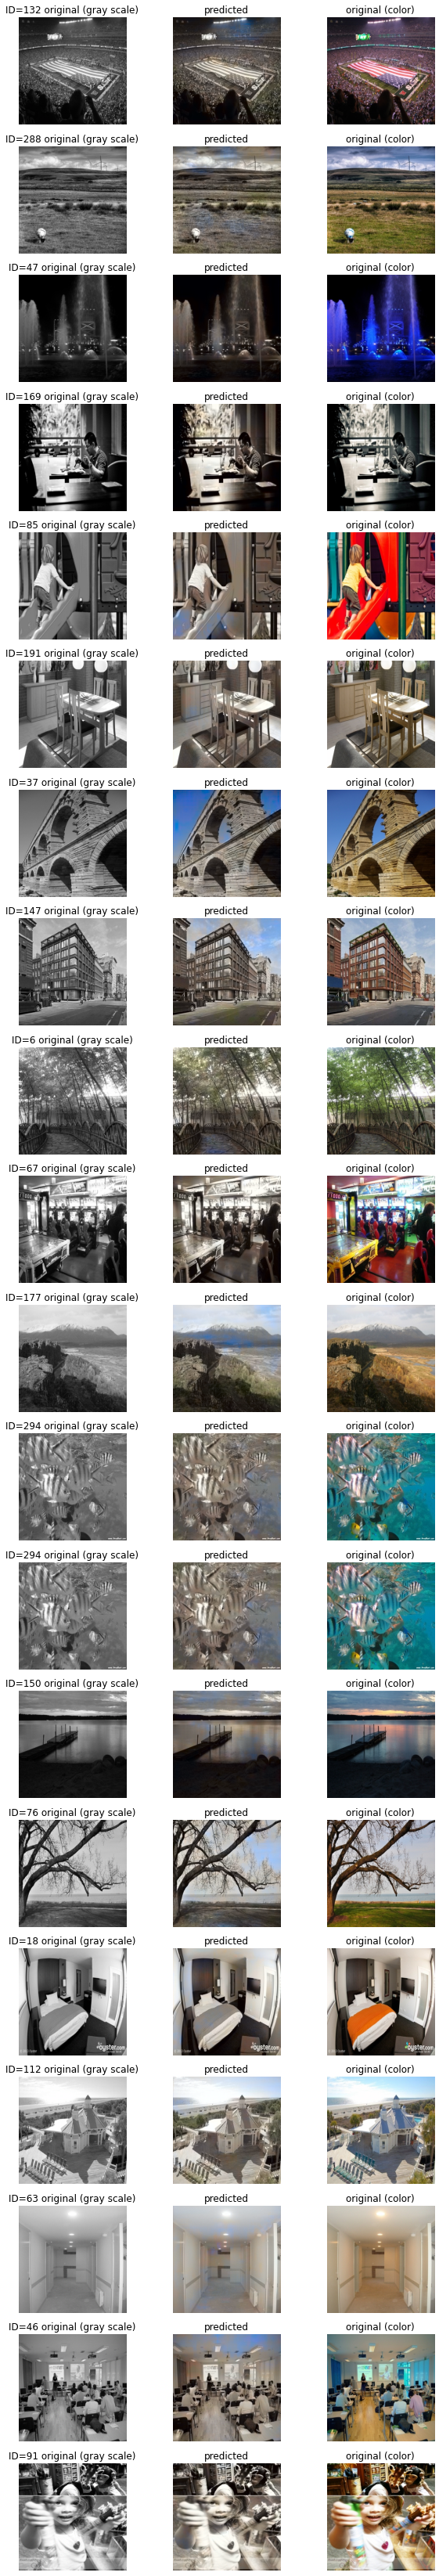

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000002417A0287C8>>

In [30]:
from copy import copy
from matplotlib import pyplot as plt

def plot_gray_predicted_true_images(Xtest,Ypred,index,target_size):
    Npic = len(index)
    fig = plt.figure(figsize=(10,Npic*3))
    count = 1
    for i in index:
        img = copy(Xtest[i])
        cur_pred = np.zeros(target_size)
        cur_gray = np.zeros(target_size)

        cur_pred[:,:,0] = img[:,:,0]*100
        cur_gray[:,:,0] = img[:,:,0]*100
        cur_pred[:,:,1:] = Ypred[i]* 128

        rgb_cur_pred = lab2rgb(cur_pred)
        rgb_cur_gray = lab2rgb(cur_gray)

        ax = fig.add_subplot(Npic,3,count)
        ax.imshow(rgb_cur_gray)
        ax.set_title("ID={} original (gray scale)".format(i))
        ax.axis("off")
        count += 1

        ax = fig.add_subplot(Npic,3,count)
        ax.imshow(rgb_cur_pred)
        ax.axis("off")
        ax.set_title("predicted")
        count += 1

        ## create original image
        img_o = np.zeros(target_size)
        img_o[:,:,0] = img[:,:,0]*100
        img_o[:,:,1:] = img[:,:,1:]*128

        ax = fig.add_subplot(Npic,3,count)
        rgb = lab2rgb(img_o)
        ax.imshow(rgb)
        ax.set_title("original (color)")
        ax.axis("off")
        count += 1
    plt.show()

Npic = 20

exampleIDs = [132,288,47,169,85,191,37,147]
randomIDs = list(np.random.choice(range(Xtest.shape[0]),Npic-len(exampleIDs)))
index = exampleIDs + randomIDs    
plot_gray_predicted_true_images(Xtest,Ypred,index,target_size)
model .predict

# save model

In [11]:
#save model
from sklearn.externals import joblib
filename = 'finalized_model.joblib'
joblib.dump(model, filename)

['finalized_model.joblib']

In [13]:
model_json = model.to_json()
with open("finalized_model.json", "w") as json_file:
    json_file.write(model_json)

In [14]:
model.save_weights("finalized_model.h5")

# load model


In [13]:
from keras.models import model_from_json
json_file = open('finalized_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

In [14]:
loaded_model=define_model()
loaded_model.load_weights("finalized_model.h5")

# checking MSE of loaded model

In [24]:
Ypred = loaded_model.predict(Xtest[:,:,:,[0]])
print("testing MSE={:4.3f}".format(np.mean((Ypred - Xtest[:,:,:,2:])**2)))

testing MSE=0.016


# Function that takes a greyscale image and plot its colorized version

In [2]:
def colorize(dir_data):
    target_size = (256,256,3)
    imgrgb = img_to_array(load_img(dir_data,target_size=target_size))/255
    imglab = rgb2lab(imgrgb)
    imgl = imglab[:,:,0]/100
    imgl = imgl.reshape(1,256,256,1)
    imgab = loaded_model.predict(imgl)
    imgl = imgl.reshape(256,256,1)
    imgab = imgab.reshape(256,256,2)
    predicted_lab = []
    for i in range(256):
        y = []
        for j in range (256):
            x = []
            x.append(imgl[i][j][0]*100)
            x.append(imgab[i][j][0]*128)
            x.append(imgab[i][j][1]*128)
            y.append(x)
        predicted_lab.append(y)
    predicted_lab = np.array(predicted_lab)
    plt.subplot(1,2,1).axis('off')
    plt.imshow(imgrgb)
    plt.subplot(1,2,2).axis('off')
    plt.imshow(lab2rgb(predicted_lab))
    plt.show()

# Some input image from our choosing

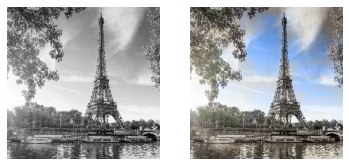

In [135]:
colorize("C:/Users/moham/Desktop/tower.jpg")

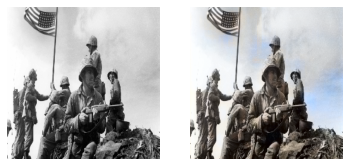

In [137]:
colorize("C:/Users/moham/Desktop/ww2.jpg")

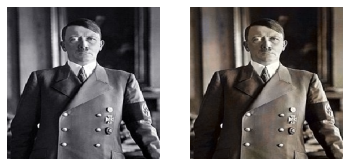

In [132]:
colorize("C:/Users/moham/Desktop/hitler.jpg")

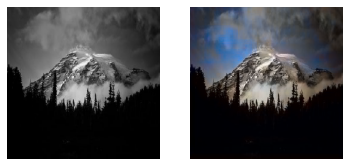

In [141]:
colorize("C:/Users/moham/Desktop/mountain.jpeg")

In [1]:
colorize("test1.jpg")

NameError: name 'colorize' is not defined